# CMAP analysis

In this notebook we analyze available gene expressio data from the CMAP data set of U2OS cells in various overexpression conditions including those covered in our structural regulators. The idea is to better understand the clustering of the gene expression profiles and the corresponding co-clustering with the currently inferred pyhsical space estimate. Additionally, we aim to preprocess the data such that it can be used later to infer the regulatory network of U2OS cells which will be the basis for the modelling of the regulatory space.

---

## 0. Environmental setup

First, we setup the environment by loading required packages.

In [338]:
import pandas as pd
import numpy as np
from venn import venn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from cmapPy.pandasGEXpress.parse import parse

import sys
from yellowbrick.cluster import KElbowVisualizer

sys.path.append("../../..")
from src.utils.notebooks.ppi.embedding import plot_tsne_embs
from src.utils.notebooks.images.embedding import *
from src.utils.torch.network import *
from src.utils.notebooks.ppi.embedding import *

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

---

## 1. Read in data

Next, we read in all the required data sets which include the CMAP data and corresponding metadata as well as a number of gene sets that we will look at later in order to compare the observed structure to our inferred structural space, which we will also load into membry.

In [161]:
sig_info = pd.read_csv("../../../data/gex/cmap/siginfo_beta.txt", sep="\t")
gene_info = pd.read_csv("../../../data/gex/cmap/geneinfo_beta.txt", sep="\t")
cell_info = pd.read_csv("../../../data/gex/cmap/cellinfo_beta.txt", sep="\t")
l5_oe_gex_data = parse(
    "../../../data/gex/cmap/level5_beta_trt_oe_n34171x12328.gctx"
).data_df.transpose()
l5_ctl_gex_data = parse(
    "/home/paysan_d/Downloads/level5_beta_ctl_n58022x12328.gctx"
).data_df.transpose()
l5_oe_gex_data = l5_ctl_gex_data.append(l5_oe_gex_data)

/home/paysan_d/miniconda3/envs/image2reg/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,3,4,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<IPython.core.display.Javascript object>

In [162]:
struct_embs = pd.read_hdf(
    "../../../data/experiments/image_embeddings/specificity_target_emb_cv_strat/final_1024/fold_0/test_latents.h5"
)

label_dict = {
    "AKT1S1": 0,
    "ATF4": 1,
    "BAX": 2,
    "BCL2L11": 3,
    "BRAF": 4,
    "CASP8": 5,
    "CDC42": 6,
    "CDKN1A": 7,
    "CEBPA": 8,
    "CREB1": 9,
    "CXXC4": 10,
    "DIABLO": 11,
    "E2F1": 12,
    "ELK1": 13,
    "EMPTY": 14,
    "ERG": 15,
    "FGFR3": 16,
    "FOXO1": 17,
    "GLI1": 18,
    "HRAS": 19,
    "IRAK4": 20,
    "JUN": 21,
    "MAP2K3": 22,
    "MAP3K2": 23,
    "MAP3K5": 24,
    "MAP3K9": 25,
    "MAPK7": 26,
    "MOS": 27,
    "MYD88": 28,
    "PIK3R2": 29,
    "PRKACA": 30,
    "PRKCE": 31,
    "RAF1": 32,
    "RELB": 33,
    "RHOA": 34,
    "SMAD4": 35,
    "SMO": 36,
    "SRC": 37,
    "SREBF1": 38,
    "TRAF2": 39,
    "TSC2": 40,
    "WWTR1": 41,
}
label_dict = dict(zip(list(label_dict.values()), list(label_dict.keys())))
struct_embs.loc[:, "labels"] = np.array(struct_embs.labels.map(label_dict))
mean_struct_embs = struct_embs.groupby("labels").mean()

oe_targets = set(mean_struct_embs.index) - {"EMPTY"}

<IPython.core.display.Javascript object>

In [163]:
node_embs = pd.read_csv(
    "../../../data/ppi/embedding/node_embeddings_cv_1024_2gexrecon_1graphrecon_mask_loss_newnodeset.csv",
    index_col=0,
)

<IPython.core.display.Javascript object>

---

## 2. Data preprocessing

To preprocess the data, we briefly filter out any signatures of the CMAP data set that are not related to any of structural regulators and or were not obtained from our cell type of interest: U2OS.

In [164]:
sig_info = sig_info.loc[
    (sig_info["project_code"] == "TA") & (sig_info["cell_iname"] == "U2OS")
]
sig_info = sig_info.loc[sig_info["pert_type"].isin(["trt_oe", "ctl_untrt"])]
# sig_info = sig_info.loc[sig_info["cmap_name"].isin(list(oe_targets))]
sig_info.index = np.array(sig_info.sig_id)
sig_info.head(5)

bead_batch  nearest_dose  pert_dose  \
TA.OE005_U2OS_72H:BRDN0000464889:1        b15           NaN        1.0   
TA.OE005_U2OS_72H:BRDN0000407676:1        b15           NaN        1.0   
TA.OE005_U2OS_72H:BRDN0000464938:1        b15           NaN        1.0   
TA.OE005_U2OS_72H:BRDN0000459386:1        b15           NaN        1.0   
TA.OE005_U2OS_72H:BRDN0000399961:1        b15           NaN        1.0   

                                   pert_dose_unit pert_idose pert_itime  \
TA.OE005_U2OS_72H:BRDN0000464889:1             uL       1 uL       72 h   
TA.OE005_U2OS_72H:BRDN0000407676:1             uL       1 uL       72 h   
TA.OE005_U2OS_72H:BRDN0000464938:1             uL       1 uL       72 h   
TA.OE005_U2OS_72H:BRDN0000459386:1             uL       1 uL       72 h   
TA.OE005_U2OS_72H:BRDN0000399961:1             uL       1 uL       72 h   

                                    pert_time pert_time_unit cell_mfc_name  \
TA.OE005_U2OS_72H:BRDN0000464889:1       72.0              h          U2OS   
TA.OE005_U2OS_72H:BRDN0000407676:1       72.0              h          U2OS   
TA.OE005_U2OS_72H:BRDN0000464938:1       72.0              h          U2OS   
TA.OE005_U2OS_72H:BRDN0000459386:1       72.0              h          U2OS   
TA.OE005_U2OS_72H:BRDN0000399961:1       72.0              h          U2OS   

                                       pert_mfc_id  ...  cell_iname  \
TA.OE005_U2OS_72H:BRDN0000464889:1  BRDN0000464889  ...        U2OS   
TA.OE005_U2OS_72H:BRDN0000407676:1  BRDN0000407676  ...        U2OS   
TA.OE005_U2OS_72H:BRDN0000464938:1  BRDN0000464938  ...        U2OS   
TA.OE005_U2OS_72H:BRDN0000459386:1  BRDN0000459386  ...        U2OS   
TA.OE005_U2OS_72H:BRDN0000399961:1  BRDN0000399961  ...        U2OS   

                                    det_wells  \
TA.OE005_U2OS_72H:BRDN0000464889:1        O02   
TA.OE005_U2OS_72H:BRDN0000407676:1        I01   
TA.OE005_U2OS_72H:BRDN0000464938:1        J01   
TA.OE005_U2OS_72H:BRDN0000459386:1        G04   
TA.OE005_U2OS_72H:BRDN0000399961:1        O13   

                                                                           det_plates  \
TA.OE005_U2OS_72H:BRDN0000464889:1  TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....   
TA.OE005_U2OS_72H:BRDN0000407676:1                           TA.OE005_U2OS_72H_X1_B15   
TA.OE005_U2OS_72H:BRDN0000464938:1                           TA.OE005_U2OS_72H_X1_B15   
TA.OE005_U2OS_72H:BRDN0000459386:1  TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....   
TA.OE005_U2OS_72H:BRDN0000399961:1  TA.OE005_U2OS_72H_X1_B15|TA.OE005_U2OS_72H_X2....   

                                                                           distil_ids  \
TA.OE005_U2OS_72H:BRDN0000464889:1  TA.OE005_U2OS_72H_X1_B15:O02|TA.OE005_U2OS_72H...   
TA.OE005_U2OS_72H:BRDN0000407676:1                       TA.OE005_U2OS_72H_X1_B15:I01   
TA.OE005_U2OS_72H:BRDN0000464938:1                       TA.OE005_U2OS_72H_X1_B15:J01   
TA.OE005_U2OS_72H:BRDN0000459386:1  TA.OE005_U2OS_72H_X1_B15:G04|TA.OE005_U2OS_72H...   
TA.OE005_U2OS_72H:BRDN0000399961:1  TA.OE005_U2OS_72H_X1_B15:O13|TA.OE005_U2OS_72H...   

                                    build_name project_code  cmap_name  \
TA.OE005_U2OS_72H:BRDN0000464889:1         NaN           TA      SMAD3   
TA.OE005_U2OS_72H:BRDN0000407676:1         NaN           TA      WNT5A   
TA.OE005_U2OS_72H:BRDN0000464938:1         NaN           TA    HSP90B1   
TA.OE005_U2OS_72H:BRDN0000459386:1         NaN           TA     PIK3CA   
TA.OE005_U2OS_72H:BRDN0000399961:1         NaN           TA       TP53   

                                    is_exemplar_sig  is_ncs_sig  is_null_sig  
TA.OE005_U2OS_72H:BRDN0000464889:1                1         1.0          0.0  
TA.OE005_U2OS_72H:BRDN0000407676:1                0         0.0          0.0  
TA.OE005_U2OS_72H:BRDN0000464938:1                0         0.0          0.0  
TA.OE005_U2OS_72H:BRDN0000459386:1                1         1.0          0.0  
TA.OE005_U2OS_72H:BRDN0000399961:1    

<IPython.core.display.Javascript object>

In [509]:
len(sig_info)

325

<IPython.core.display.Javascript object>

There are 325 gene signatures available in total corresponding to the different OE and control experiments with U2OS cells. There are 61 gene signatures available for all 41 structural regulators. Note that only 49/64 of these signatures are flagged as being of high quality. We note that the poor quality measurements correlate with interventions that had been flagged as having a toxic effect thus killing a substantial amount of the cells.

We will construct averaged gene sigantures for each overexpression conditions described above.

In [165]:
gene_id_symbol_dict = dict(
    zip(gene_info.loc[:, "gene_id"].astype(str), gene_info.loc[:, "gene_symbol"])
)
l5_oe_gex_data = l5_oe_gex_data.rename(gene_id_symbol_dict, axis=1)
l5_data = l5_oe_gex_data.loc[set(sig_info.sig_id)].copy()
l5_data["labels"] = np.array(sig_info.loc[l5_data.index, "cmap_name"])
mean_l5_data = l5_data.copy()
mean_l5_data["labels"] = np.array(sig_info.loc[mean_l5_data.index, "cmap_name"])
mean_l5_data = mean_l5_data.groupby("labels").mean()
mean_l5_data.head()

rid         NAT2       ADA      CDH2      AKT3      MED6   NAALAD2  NAALADL1  \
labels                                                                         
ACVR1B  0.382983  0.273100  0.556467  0.014800  0.108117  0.368000  0.534183   
ADAM17 -0.321200 -0.866750 -0.070550  0.100850 -0.393200  1.122850  0.036250   
AKT1   -0.516100 -0.810000  0.099400 -0.500933 -0.105000 -0.560267  0.071867   
AKT1S1  0.161675 -0.486725  0.648050  0.880625 -0.174125  1.154400  0.192925   
AKT2   -1.160950  0.428450 -0.063650 -1.065950 -0.131850 -0.108450  0.117800   

rid        ACOT8      ABI1    GNPDA1  ...      REC8   HNRNPDL     DMTF1  \
labels                                ...                                 
ACVR1B  0.390683 -0.214333  0.201783  ...  0.541300 -0.179367 -0.463917   
ADAM17  0.468750 -0.743700  0.034900  ...  0.345050 -0.369750 -0.322050   
AKT1    0.357167 -0.135917 -0.618183  ...  0.356483  0.234067  0.362783   
AKT1S1  0.297125 -0.207900  0.863800  ...  0.080525  0.684025 -0.573075   
AKT2   -0.130300 -0.584200  0.209750  ... -0.220450  1.569800 -1.108100   

rid       PPP4R1      CDH1   SLC12A6     PTBP3     KCNE2     DGCR2      SCO2  
labels                                                                        
ACVR1B  0.169100 -1.299350 -0.120550 -0.093567  0.095350  0.599783  0.324317  
ADAM17 -0.210700  1.434200  0.058050 -0.212450  0.599150 -0.007250  1.124700  
AKT1    0.904867 -0.072367 -0.444233  0.559650  0.015817 -0.102150  0.212633  
AKT1S1  0.495225 -1.047250  0.352625  0.582375 -0.536525 -0.496625  0.970000  
AKT2    0.556550  0.411900 -0.621400  0.083950 -0.689700 -0.603000  1.102050  

[5 rows x 12328 columns]

<IPython.core.display.Javascript object>

---

## 3. Exploratory analysis


### 3.1. Gene coverage

Next, we focus on the genes captured in the computed signatures and look at the coverage of our structural regulators in gene subsets of different inference quality.

In [78]:
l1000_genes = set(gene_info.loc[gene_info.feature_space == "landmark", "gene_symbol"])
best_inf_genes = set(
    gene_info.loc[gene_info.feature_space == "best inferred", "gene_symbol"]
)
inf_genes = set(gene_info.loc[gene_info.feature_space == "inferred", "gene_symbol"])
not_rep_genes = set(
    gene_info.loc[gene_info.feature_space == "not reported", "gene_symbol"]
)

<IPython.core.display.Javascript object>

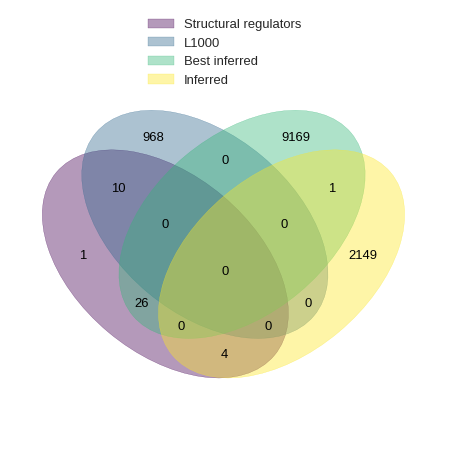

<IPython.core.display.Javascript object>

In [79]:
ax = venn(
    {
        "Structural regulators": oe_targets,
        "L1000": l1000_genes,
        "Best inferred": best_inf_genes,
        "Inferred": inf_genes,
    },
    legend_loc="upper center",
)

We find that 10/41 structural regulators are in the L1000 gene set, 26/41 of the regulators are in the set of best inferred genes and just one structural regulatory, namely AKT1S1 is not covered in the gene set.

---

### 3.2. Clustering of the gene signatures

As a first step we aim to understand the similarity of the gene signatures with our inferred structural embeddings.


#### Clustering of the physical space

To this end, we will briefly cluster the physical space and compare it to the gene signatures. Since the gene signatures are describing pooled differential expression levels, we will also pool our structural embeddings and cluster the mean embeddings for each gene.

We next will identify the optimal number of clusters in the structural space by looking at the a number of metrics proposed earlier.

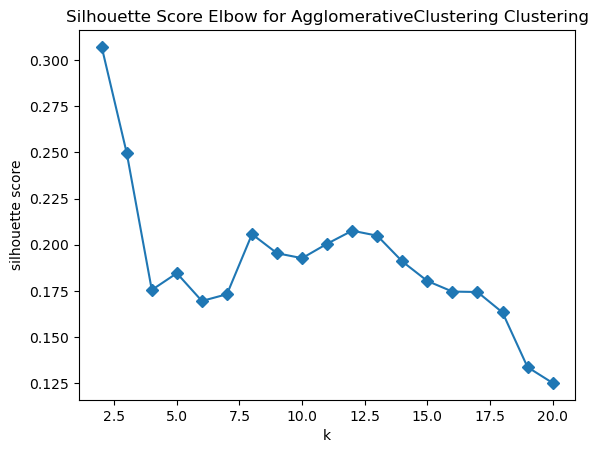

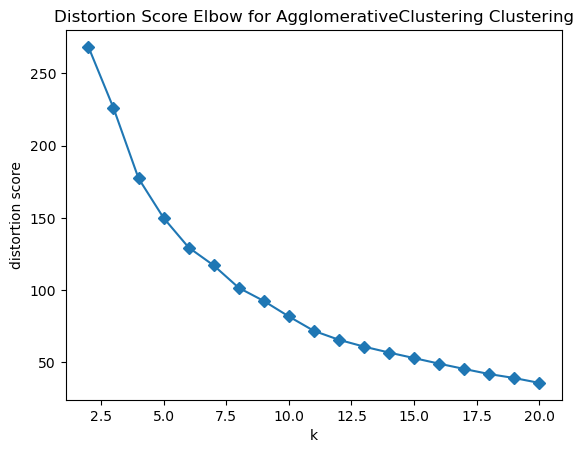

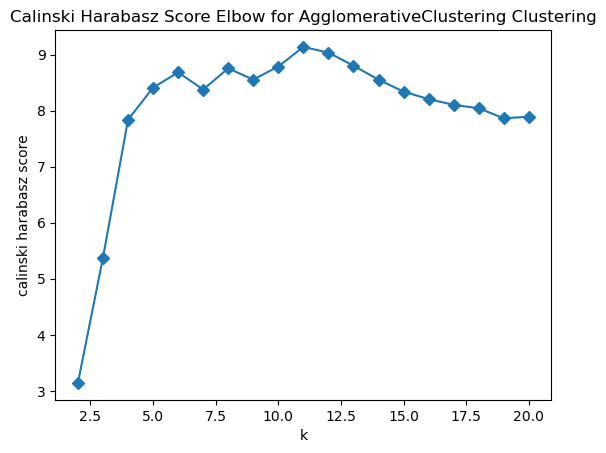

<IPython.core.display.Javascript object>

In [302]:
model = AgglomerativeClustering(affinity="euclidean", linkage="complete")
visualizer = KElbowVisualizer(
    model, k=20, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(mean_struct_embs.loc[oe_targets])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=20, metric="distortion", timings=False, locate_elbow=False
)

visualizer.fit(mean_struct_embs.loc[oe_targets])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=20, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(mean_struct_embs.loc[oe_targets])
ax = visualizer.show()

The above plots indicate that the data is best divided into 11 clusters as this maximizes the Calinski-Harabsz score and reaches a local optima of the Silhouette score. Thus, we focus at the solution consisting of 11 clusters.

In [301]:
model = AgglomerativeClustering(n_clusters=11, affinity="euclidean", linkage="complete")
struct_cluster_labels = model.fit_predict(mean_struct_embs.loc[oe_targets])
struct_clusters = pd.DataFrame(
    struct_cluster_labels,
    index=mean_struct_embs.loc[oe_targets].index,
    columns=["cluster"],
)
lut = dict(
    zip(
        list(np.unique(struct_cluster_labels)),
        [
            "tab:blue",
            "tab:red",
            "tab:green",
            "gold",
            "tab:orange",
            "tab:cyan",
            "purple",
            "tab:pink",
            "tab:olive",
            "tab:cyan",
            "tab:brown",
        ],
    )
)
struct_colors = pd.Series(
    struct_cluster_labels,
    index=mean_struct_embs.loc[oe_targets].index,
).map(lut)

<IPython.core.display.Javascript object>

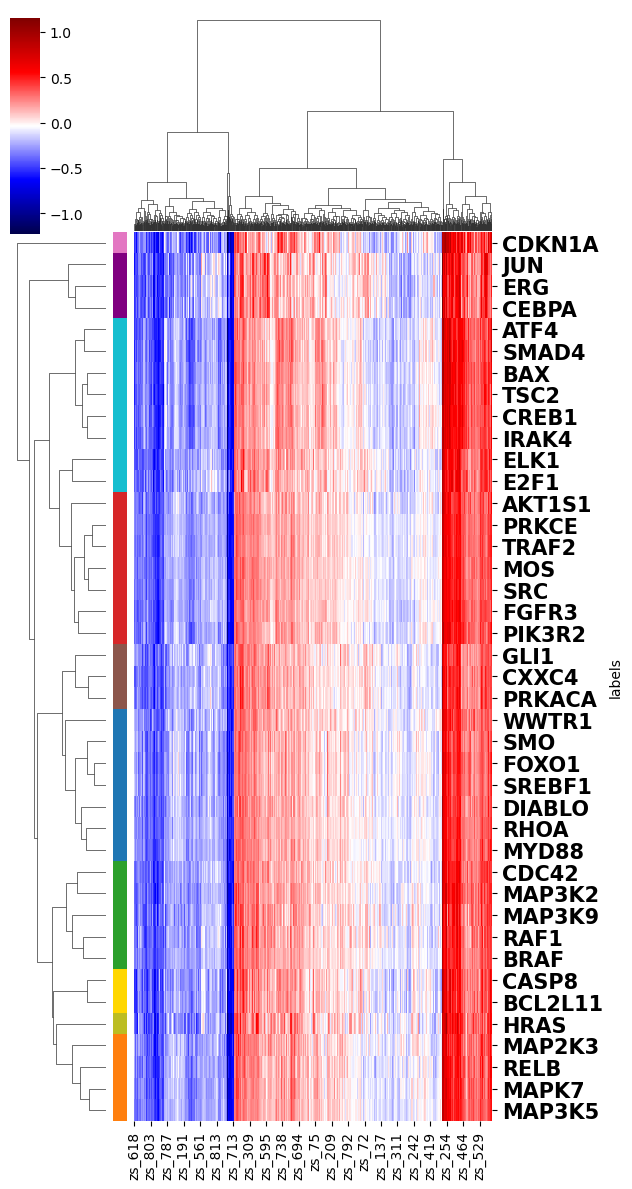

<IPython.core.display.Javascript object>

In [307]:
ax = sns.clustermap(
    mean_struct_embs.loc[oe_targets],
    figsize=[6, 12],
    metric="euclidean",
    cmap="seismic",
    method="complete",
    row_colors=np.array(struct_colors.loc[mean_struct_embs.loc[oe_targets].index]),
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
plt.show()

The cluster plot above shows the observed clustering of our structural space. Since, the clustering will be used for additional analysis we save the corresponding solution to disk.

In [ ]:
struct_clusters.to_csv("../../../data/other/mean_physical_clusters.csv")

---

#### Clustering of the functional (CMAP signature) space

Next, we cluster the CMAP signatures again using hierarchical clustering with complete linkage but using cosine similarity to identify cluster of overexpression settings that lead to changes of the same directionality in the gene expression space. To visualize the correspondence of the clustering of the functional and physical space, the physical space clusters are transfered by color-coding the corresponding genes in the cluster map below.

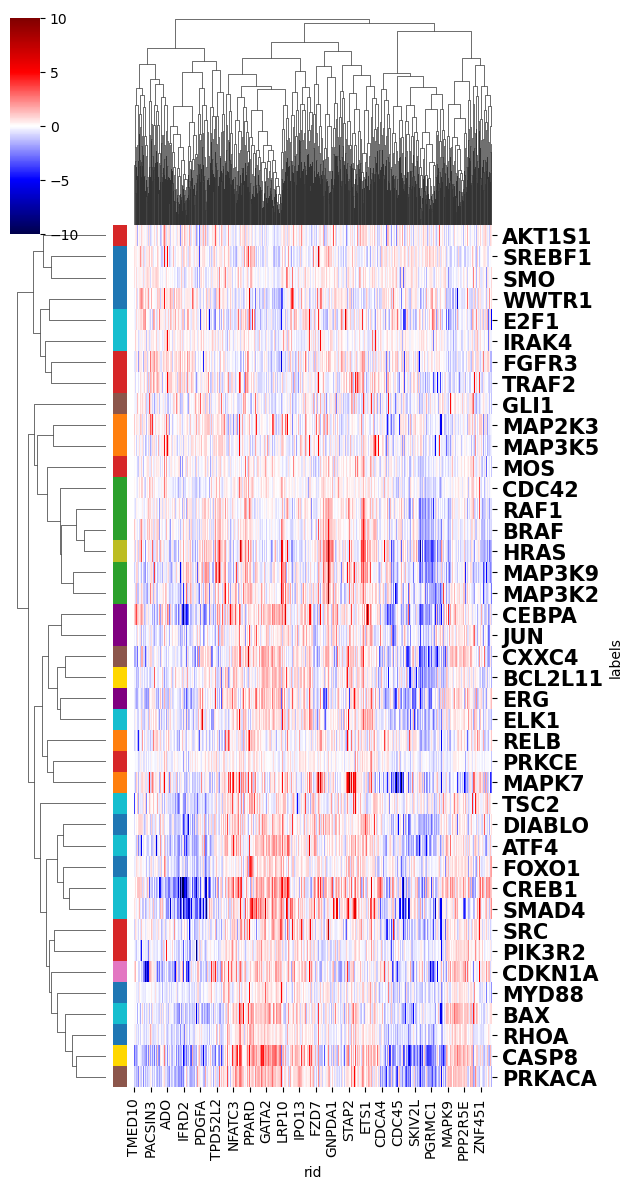

<IPython.core.display.Javascript object>

In [304]:
ax = sns.clustermap(
    mean_l5_data.loc[oe_targets, l1000_genes],
    figsize=[6, 12],
    metric="cosine",
    cmap="seismic",
    method="complete",
    row_colors=np.array(struct_colors.loc[mean_l5_data.loc[oe_targets].index]),
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
plt.show()

The plot above suggests that there is a non-random co-clustering of the physical and the functional space as e.g. the green cluster of BRAF, RAF1, MAP3K2, MAP3K9 and HRAS are observed in both spaces. Additionaly we observe a number of gene pairs co-clustering in the two spaces like JUN and CEBPA or CREB1 and SMAD4.

The non-random agreement of the co-clustering of the physical and the CMAP space is further shown in the plot below showing the bootstrap p-values for the mutual information of for varying number of clusters in the physical and functional space obtained via hierarchical clustering using complete linkage and euclidean and cosine simularity respectively. We obtained 500 bootstrap samples by randomly permuting the cluster labels for each pair of cluster solutions defined by the corresponding dendogram cut in the two clustered spaces following the procedure described in .

In [510]:
# We will focus on all genes that are covered in the physical, regulatory and functional space
shared_genes = (
    set(mean_struct_embs.index)
    .intersection(mean_l5_data.index)
    .intersection(node_embs.index)
)
ami_img_cmap = compute_ami_matrix(
    mean_struct_embs.loc[shared_genes],
    mean_l5_data.loc[shared_genes, l1000_genes],
    linkage="complete",
    affinity=["euclidean", "cosine"],
)

<IPython.core.display.Javascript object>

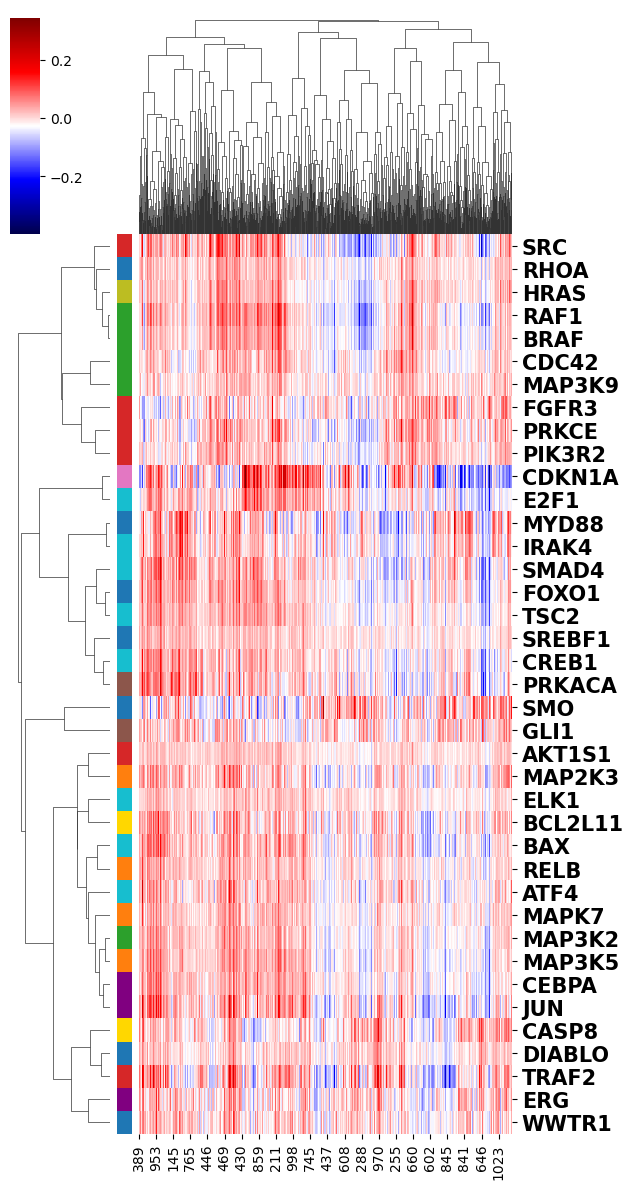

<IPython.core.display.Javascript object>

In [305]:
ax = sns.clustermap(
    node_embs.loc[oe_targets.intersection(node_embs.index)],
    figsize=[6, 12],
    metric="cosine",
    cmap="seismic",
    method="complete",
    row_colors=np.array(
        struct_colors.loc[node_embs.loc[oe_targets.intersection(node_embs.index)].index]
    ),
)
ax.ax_heatmap.set_yticklabels(
    ax.ax_heatmap.get_ymajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
plt.show()

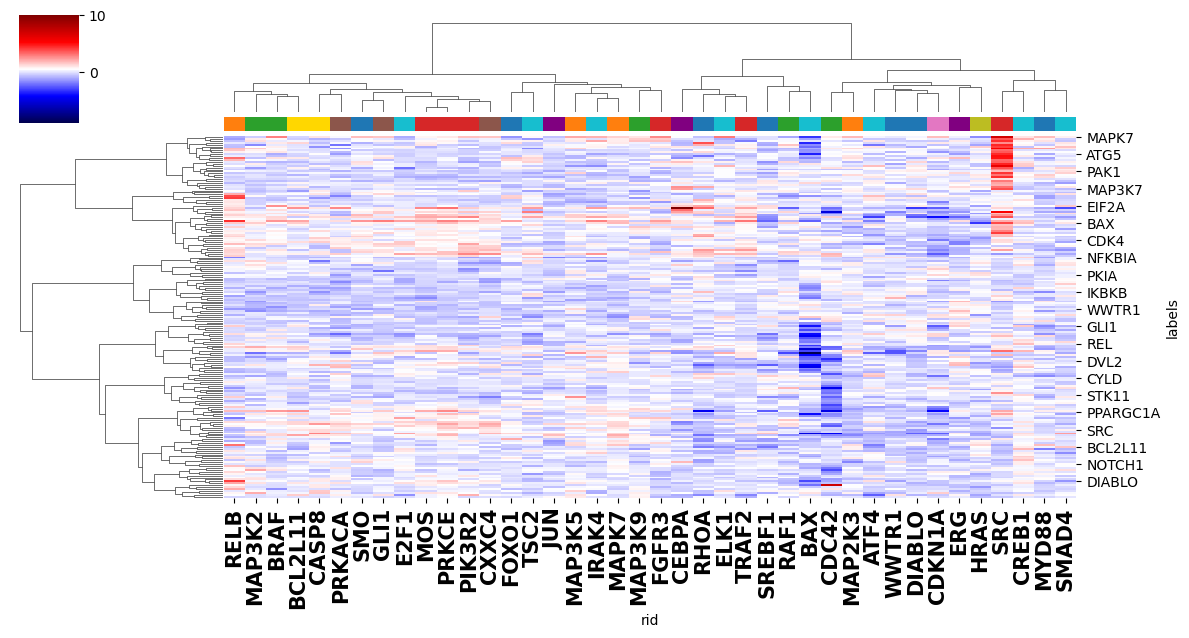

<IPython.core.display.Javascript object>

In [306]:
ax = sns.clustermap(
    mean_l5_data.loc[:, oe_targets.intersection(mean_l5_data.columns)],
    figsize=[12, 6],
    metric="cosine",
    cmap="seismic",
    method="ward",
    col_colors=np.array(
        struct_colors.loc[
            mean_l5_data.loc[
                oe_targets, oe_targets.intersection(mean_l5_data.columns)
            ].columns
        ]
    ),
)
ax.ax_heatmap.set_xticklabels(
    ax.ax_heatmap.get_xmajorticklabels(),
    fontsize=15,
    fontweight="bold",
)
plt.show()

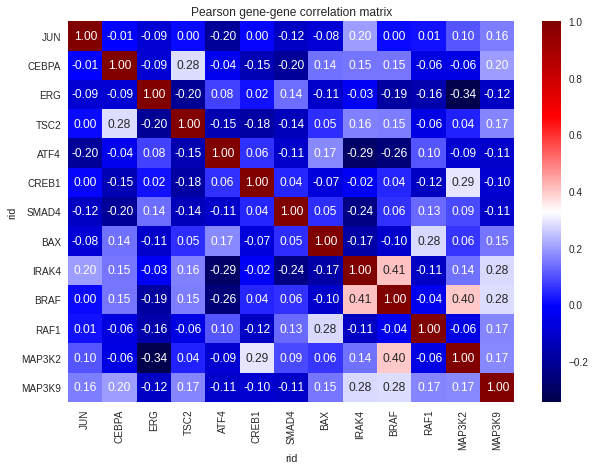

<IPython.core.display.Javascript object>

In [136]:
selection = [
    "JUN",
    "CEBPA",
    "ERG",
    "TSC2",
    "ATF4",
    "CREB1",
    "SMAD4",
    "BAX",
    "IRAK4",
    "BRAF",
    "RAF1",
    "MAP3K2",
    "MAP3K9",
]
fig, ax = plt.subplots(figsize=[10, 7])
ax = sns.heatmap(
    mean_l5_data.loc[:, selection].corr(), annot=True, cmap="seismic", ax=ax, fmt=".2f"
)
ax.set_title("Pearson gene-gene correlation matrix")
plt.show()

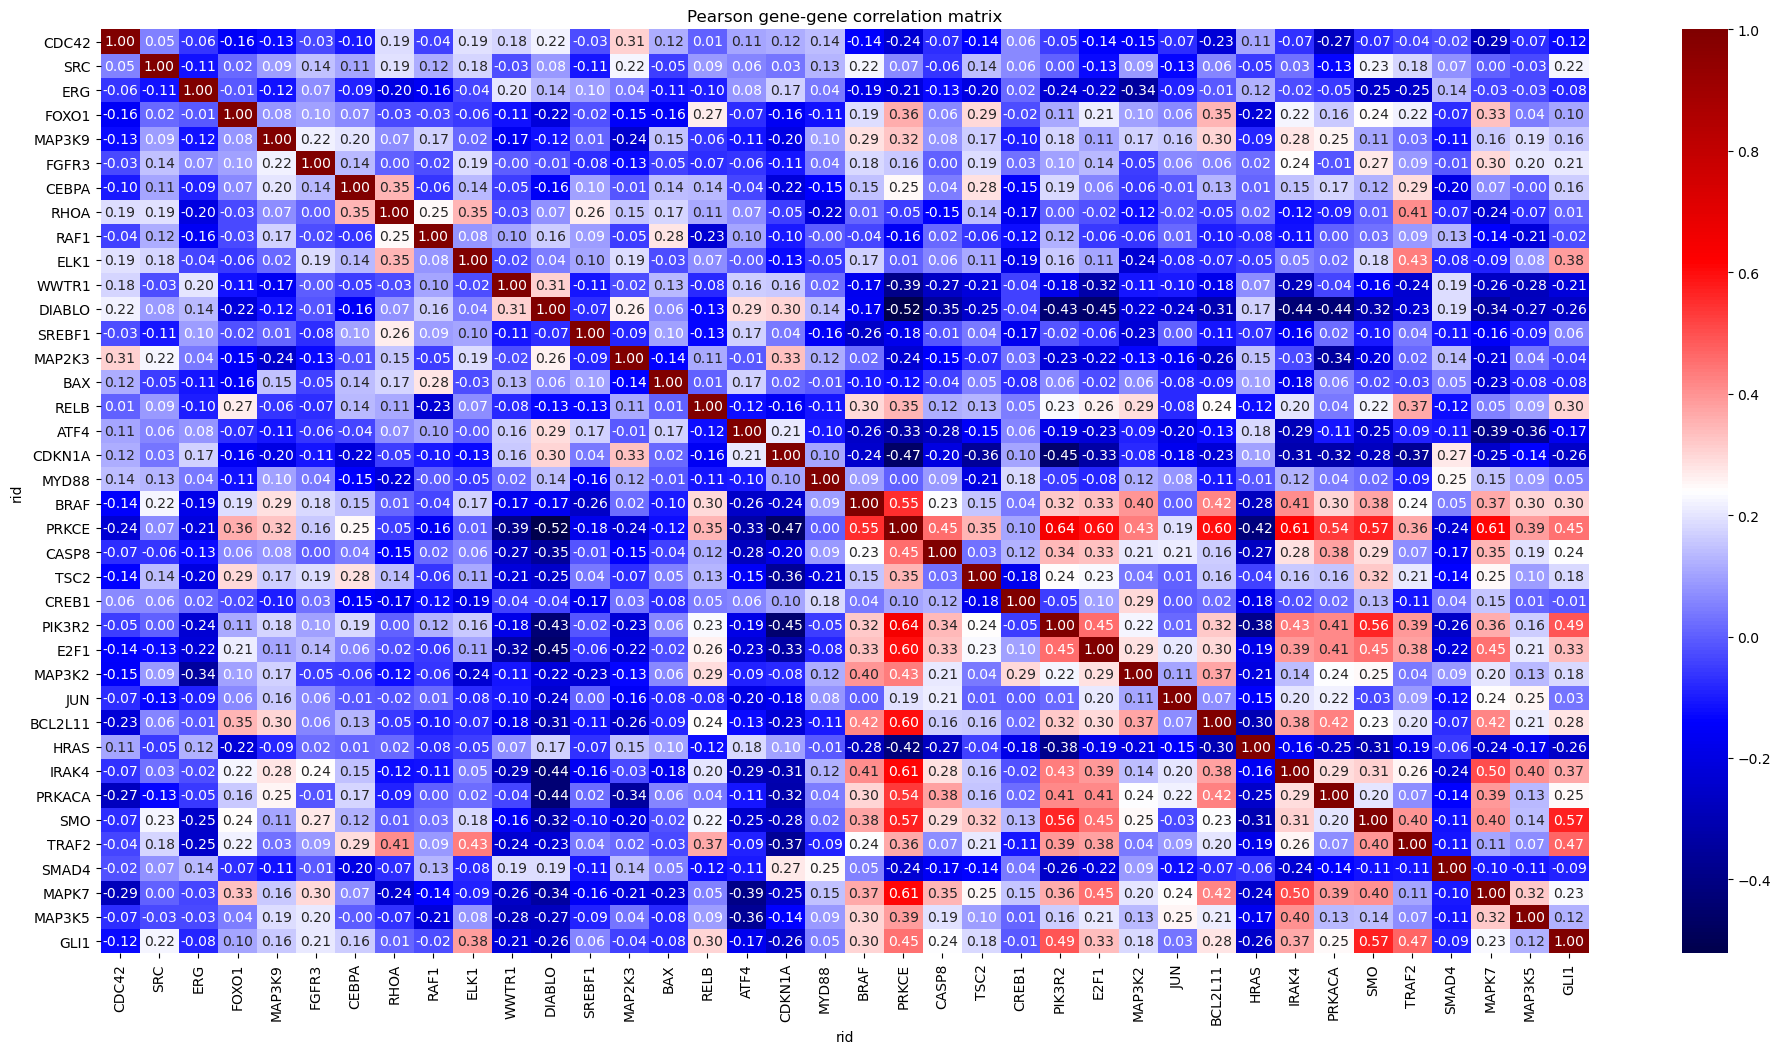

<IPython.core.display.Javascript object>

In [385]:
fig, ax = plt.subplots(figsize=[24, 12])
ax = sns.heatmap(
    mean_l5_data.loc[:, shared_genes.intersection(mean_l5_data.columns)].corr(),
    annot=True,
    cmap="seismic",
    ax=ax,
    fmt=".2f",
)
ax.set_title("Pearson gene-gene correlation matrix")
plt.show()

In [418]:
from scipy.stats import spearmanr
cascade_results= {"source":[], "target":[], "physical_cluster":[], "correlated":[]}
covered_genes = list(shared_genes.intersection(mean_l5_data.columns))

for i in range(len(covered_genes)-1):
    for j in range(i+1, len(covered_genes)):
        source = covered_genes[i]
        target = covered_genes[j]
        physical_cluster = len(np.unique(struct_clusters.loc[[source, target]])) == 1
        correlated = spearmanr(mean_l5_data.loc[:, source], mean_l5_data.loc[:, target])[1] < 0.001
        cascade_results["source"].append(source)
        cascade_results["target"].append(target)
        cascade_results["physical_cluster"].append(physical_cluster)
        cascade_results["correlated"].append(correlated)
cascade_results = pd.DataFrame(cascade_results)
        



<IPython.core.display.Javascript object>

In [423]:

    cascade_results.loc[
        (cascade_results.physical_cluster == True)
        & (cascade_results.correlated == False)
    ]


source   target  physical_cluster  correlated
3     CDC42   MAP3K9              True       False
7     CDC42     RAF1              True       False
18    CDC42     BRAF              True       False
25    CDC42   MAP3K2              True       False
40      SRC    FGFR3              True       False
55      SRC    PRKCE              True       False
59      SRC   PIK3R2              True       False
68      SRC    TRAF2              True       False
76      ERG    CEBPA              True       False
97      ERG      JUN              True       False
111   FOXO1     RHOA              True       False
114   FOXO1    WWTR1              True       False
115   FOXO1   DIABLO              True       False
116   FOXO1   SREBF1              True       False
122   FOXO1    MYD88              True       False
136   FOXO1      SMO              True       False
145  MAP3K9     RAF1              True       False
163  MAP3K9   MAP3K2              True       False
189   FGFR3    PRKCE              True       False
193   FGFR3   PIK3R2              True       False
202   FGFR3    TRAF2              True       False
227   CEBPA      JUN              True       False
240    RHOA    WWTR1              True       False
241    RHOA   DIABLO              True       False
242    RHOA   SREBF1              True       False
248    RHOA    MYD88              True       False
262    RHOA      SMO              True       False
278    RAF1     BRAF              True       False
285    RAF1   MAP3K2              True       False
312    ELK1     E2F1              True       False
326   WWTR1   SREBF1              True       False
332   WWTR1    MYD88              True       False
346   WWTR1      SMO              True       False
352  DIABLO   SREBF1              True       False
358  DIABLO    MYD88              True       False
383  SREBF1    MYD88              True       False
397  SREBF1      SMO              True       False
404  MAP2K3     RELB              True       False
424  MAP2K3    MAPK7              True       False
425  MAP2K3   MAP3K5              True       False
428     BAX     ATF4              True       False
434     BAX     TSC2              True       False
435     BAX    CREB1              True       False
442     BAX    IRAK4              True       False
446     BAX    SMAD4              True       False
469    RELB    MAPK7              True       False
470    RELB   MAP3K5              True       False
477    ATF4     TSC2              True       False
478    ATF4    CREB1              True       False
485    ATF4    IRAK4              True       False
489    ATF4    SMAD4              True       False
526   MYD88      SMO              True       False
573   CASP8  BCL2L11              True       False
583    TSC2    CREB1              True       False
590    TSC2    IRAK4              True       False
594    TSC2    SMAD4              True       False
604   CREB1    IRAK4              True       False
608   CREB1    SMAD4              True       False
678   IRAK4    SMAD4              True       False

<IPython.core.display.Javascript object>

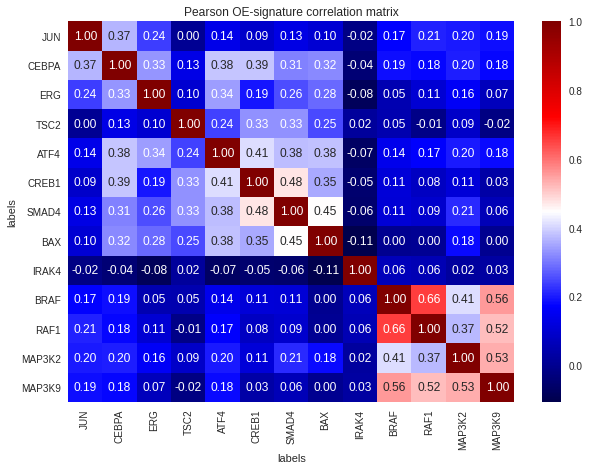

<IPython.core.display.Javascript object>

In [140]:
fig, ax = plt.subplots(figsize=[10, 7])
ax = sns.heatmap(
    mean_l5_data.loc[selection, l1000_genes].transpose().corr(),
    annot=True,
    cmap="seismic",
    ax=ax,
    fmt=".2f",
)
ax.set_title("Pearson OE-signature correlation matrix")
plt.show()

In [187]:
mean_l5_data.loc["BCL2L11", ["CASP8", "BCL2L11"]]

rid
CASP8      0.87025
BCL2L11   -1.03700
Name: BCL2L11, dtype: float32

<IPython.core.display.Javascript object>

In [183]:
tmp = list(oe_targets.intersection(mean_l5_data.columns))

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'MODZ score for selected targets in OE condition')

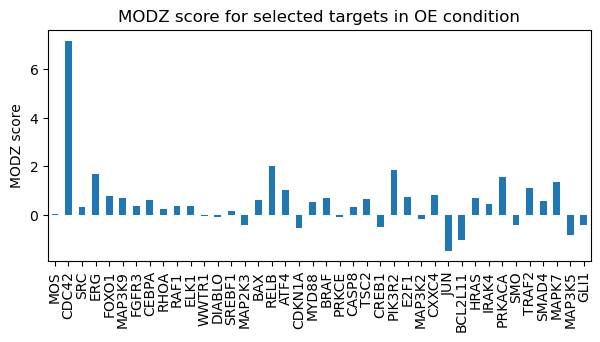

<IPython.core.display.Javascript object>

In [185]:
import matplotlib as mpl

mpl.style.use("default")
diag = pd.Series(np.diag(mean_l5_data.loc[tmp, tmp]), index=tmp)
ax = diag.plot(kind="bar", figsize=[7, 3])
ax.set_ylabel("MODZ score")
ax.set_title("MODZ score for selected targets in OE condition")

In [148]:
l5_data.loc[l5_data.labels == "CASP9", ["CASP9", "CASP8", "BCL2L11"]]

rid                                  CASP9   CASP8  BCL2L11
cid                                                        
TA.OE005_U2OS_72H:BRDN0000403504:1 -1.1733  0.9842    2.578

<IPython.core.display.Javascript object>

The above clustering suggest that at least some clustering structure are preserved. For instance TSC2, ATF4, SMAD4, CREB1 and BAX co-cluster in both the CMAP gene signature space as well as in the structural space. Similarly we find BRAF, RAF1, CDC42, MAP3K2 and MAP3K9 to co-cluster in the two spaces. MAP3K5, MAP2K3, RELB, TRAF2, MAPK7 also co-cluster in the two spaces as well as FGFR3 and GLI1.

Samples of clusters that are not well preserved are SREBF1, SMO, AKT1S1, DIABLO, RHOA and MYD88, which we have seen to cluster together in the structural space.

In [483]:
covered_targets =['ATF4', 'BAX', 'BCL2L11', 'BRAF', 'CASP8', 'CDC42', 'CDKN1A', 'CEBPA', 'CREB1', 'DIABLO', 'E2F1', 'ELK1', 'ERG', 'FGFR3', 'FOXO1', 'GLI1', 'HRAS', 'IRAK4', 'JUN', 'MAP2K3', 'MAP3K2', 'MAP3K5', 'MAP3K9', 'MAPK7', 'MYD88', 'PIK3R2', 'PRKACA', 'PRKCE', 'RAF1', 'RELB', 'RHOA', 'SMAD4', 'SMO', 'SRC', 'SREBF1', 'TRAF2', 'TSC2', 'WWTR1']


<IPython.core.display.Javascript object>

In [500]:
from coclust.clustering.spherical_kmeans import SphericalKmeans

<IPython.core.display.Javascript object>

In [504]:
from sklearn.cluster import SpectralClustering

<IPython.core.display.Javascript object>

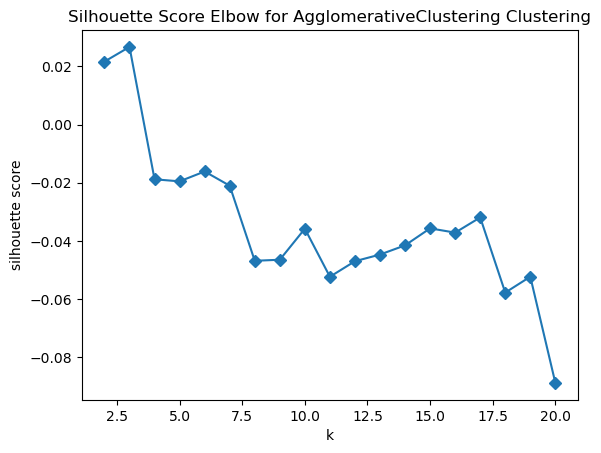

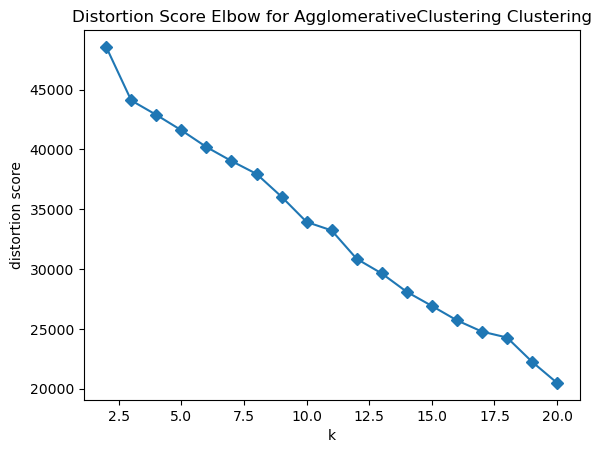

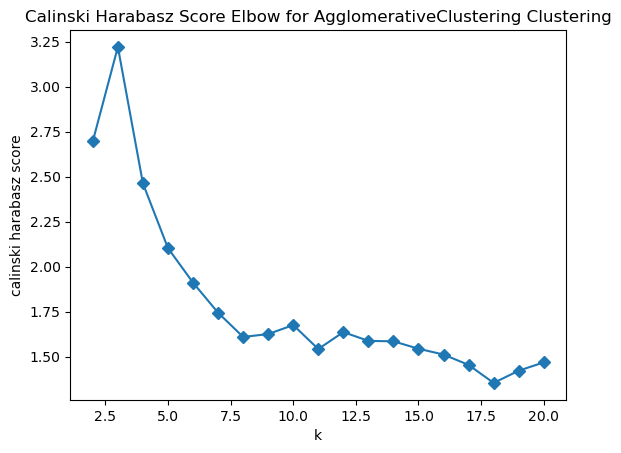

<IPython.core.display.Javascript object>

In [506]:
model = AgglomerativeClustering(affinity="cosine", linkage="complete")
# model = SpectralClustering(random_state=1234)
visualizer = KElbowVisualizer(
    model, k=20, metric="silhouette", timings=False, locate_elbow=False
)

visualizer.fit(mean_l5_data.loc[covered_targets, l1000_genes])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=20, metric="distortion", timings=False, locate_elbow=False
)

visualizer.fit(mean_l5_data.loc[covered_targets, l1000_genes])
ax = visualizer.show()

visualizer = KElbowVisualizer(
    model, k=20, metric="calinski_harabasz", timings=False, locate_elbow=False
)

visualizer.fit(mean_l5_data.loc[covered_targets, l1000_genes])
ax = visualizer.show()

In [507]:
model = AgglomerativeClustering(n_clusters=10, affinity="cosine", linkage="complete")
# model = KMeans()
l5_cluster_labels = model.fit_predict(mean_l5_data.loc[covered_targets, l1000_genes])
mean_l5_clusters = pd.DataFrame(
    l5_cluster_labels,
    index=mean_l5_data.loc[covered_targets].index,
    columns=["cluster"],
)
from collections import Counter

Counter(mean_l5_clusters.cluster)

Counter({1: 13, 8: 5, 4: 6, 2: 2, 0: 3, 9: 1, 5: 2, 3: 3, 6: 2, 7: 1})

<IPython.core.display.Javascript object>

In [508]:
for i in range(10):
    print(
        list(
            set(mean_l5_clusters.loc[mean_l5_clusters.cluster == i].index).intersection(
                oe_targets
            )
        )
    )

['FGFR3', 'TRAF2', 'IRAK4']
['SRC', 'ATF4', 'CDKN1A', 'RHOA', 'MYD88', 'PRKACA', 'DIABLO', 'CASP8', 'FOXO1', 'SMAD4', 'CREB1', 'PIK3R2', 'BAX']
['WWTR1', 'E2F1']
['RELB', 'PRKCE', 'MAPK7']
['MAP3K2', 'CDC42', 'HRAS', 'RAF1', 'BRAF', 'MAP3K9']
['MAP2K3', 'MAP3K5']
['SMO', 'SREBF1']
['TSC2']
['JUN', 'CEBPA', 'ERG', 'BCL2L11', 'ELK1']
['GLI1']


<IPython.core.display.Javascript object>

In [468]:
print(list(mean_l5_clusters.index))

['ACVR1B', 'ADAM17', 'AKT1', 'AKT1S1', 'AKT2', 'AKT3', 'APAF1', 'APC', 'ARAF', 'ARNTL', 'ATF2', 'ATF4', 'ATF6', 'ATG16L1', 'ATG5', 'ATM', 'AXIN2', 'BAMBI', 'BAX', 'BCL2L1', 'BCL2L11', 'BECN1', 'BMP2', 'BMPR1B', 'BRAF', 'BRCA1', 'BTRC', 'CARD11', 'CASP8', 'CASP9', 'CCND1', 'CCNE1', 'CDC42', 'CDK2', 'CDK4', 'CDKN1A', 'CEBPA', 'CHUK', 'CLOCK', 'CREB1', 'CREBBP', 'CRY1', 'CSNK1A1', 'CSNK1E', 'CTNNB1', 'CXXC4', 'CYLD', 'DDIT3', 'DDIT4', 'DEPTOR', 'DIABLO', 'DKK1', 'DLL1', 'DUSP1', 'DVL1', 'DVL2', 'DVL3', 'E2F1', 'EGLN1', 'EIF2A', 'EIF4E', 'EIF4EBP1', 'ELK1', 'ERBB2', 'ERG', 'ERN1', 'FGFR3', 'FH', 'FOXO1', 'FURIN', 'GLI1', 'GRB10', 'GSK3B', 'HIF1A', 'HIF1AN', 'HRAS', 'HSP90AA1', 'HSP90B1', 'HSPA5', 'IKBKB', 'IKBKE', 'IRAK1', 'IRAK4', 'IRGM', 'IRS1', 'JAG1', 'JAK2', 'JUN', 'KRAS', 'LRPPRC', 'MAP2K1', 'MAP2K3', 'MAP2K4', 'MAP3K11', 'MAP3K2', 'MAP3K5', 'MAP3K7', 'MAP3K8', 'MAP3K9', 'MAPK1', 'MAPK13', 'MAPK14', 'MAPK3', 'MAPK7', 'MAPK8', 'MAPK9', 'MAPKAP1', 'MCL1', 'MKNK1', 'MLST8', 'MOS', 'MYD8

<IPython.core.display.Javascript object>

In [322]:



ami_img_node = compute_ami_matrix(
    mean_struct_embs.loc[shared_genes],
    node_embs.loc[
        shared_genes,
    ],
    linkage="complete",
    affinity=["euclidean", "cosine"],
)

<IPython.core.display.Javascript object>

In [424]:
reg_perm_test_results = compute_cc_scores_perm_test(
    mean_struct_embs.loc[shared_genes],
    node_embs.loc[shared_genes],
    linkages=["complete", "complete"],
    affinities=["euclidean", "cosine"],
    score="mi",
    b=500,
    n_max_clusters=len(shared_genes),
)

100%|██████████| 500/500 [07:02<00:00,  1.18it/s]


<IPython.core.display.Javascript object>

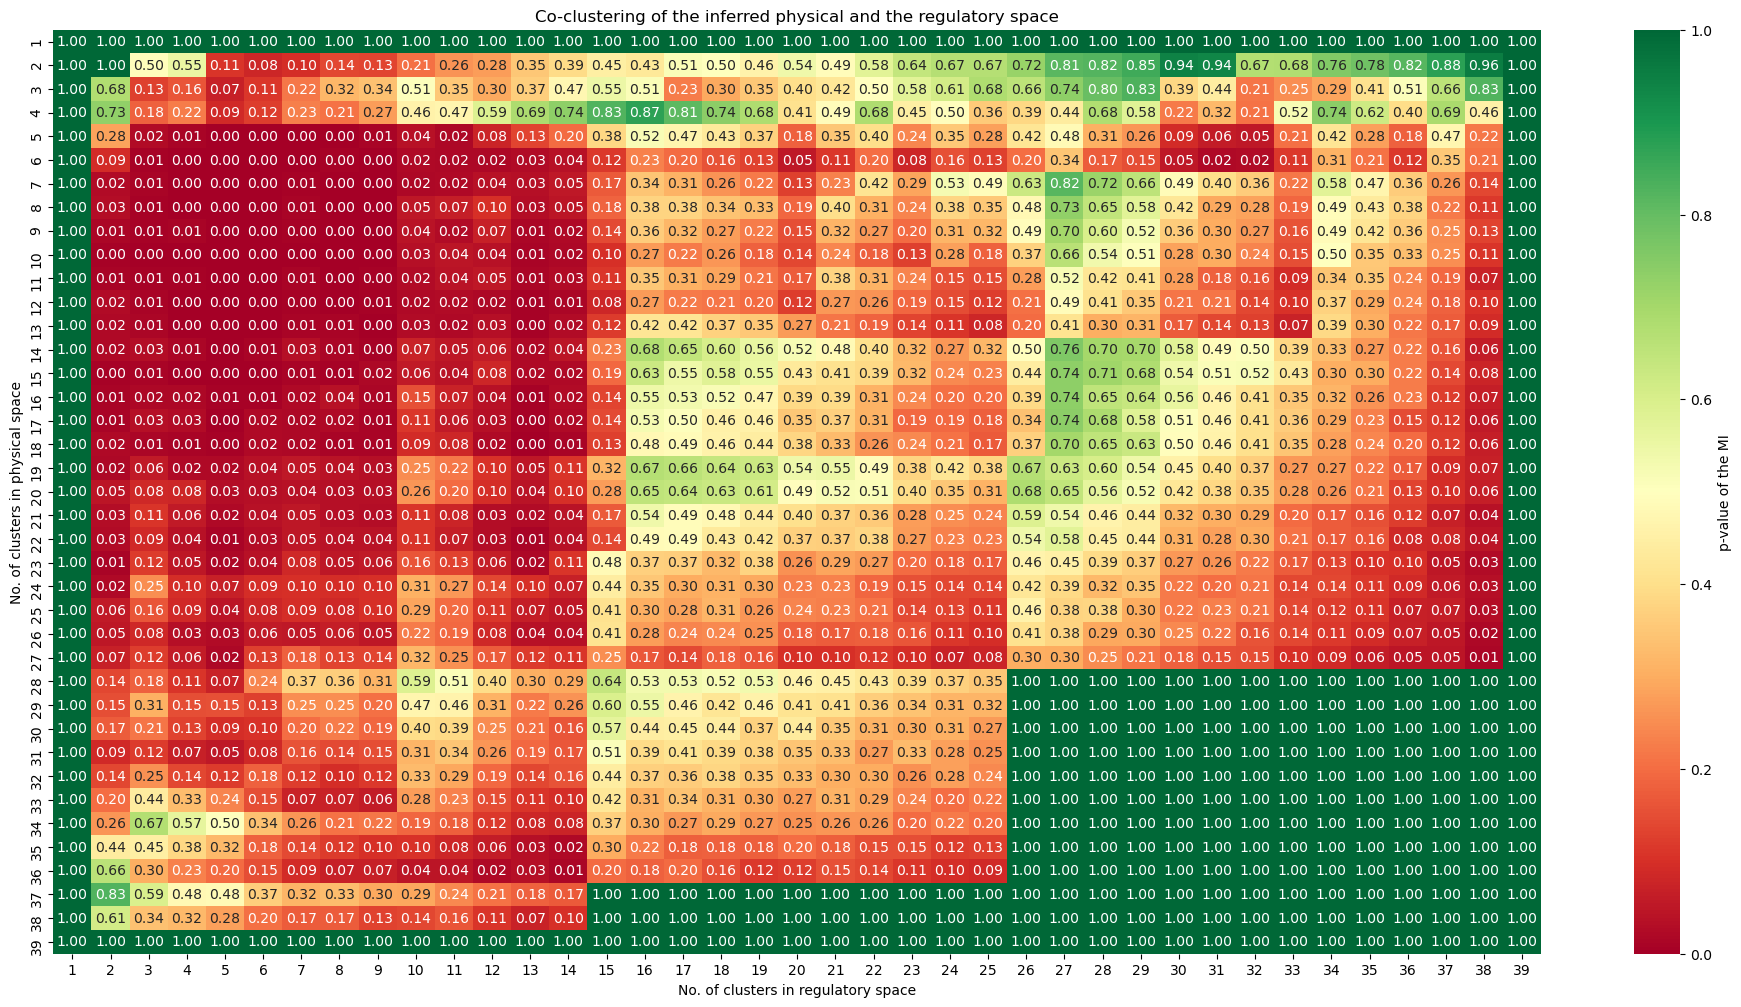

<IPython.core.display.Javascript object>

In [425]:
plot_cc_score(
    np.clip(reg_perm_test_results["pval"], 0, 1),
    "Co-clustering of the inferred physical and the regulatory space",
    "p-value of the MI",
    figsize=[24, 12],
    fmt=".2f",
    cmap="RdYlGn",
    vmin=0,
    vmax=1,
    space_names=["regulatory space", "physical space"],
)

In [426]:
cmap_perm_test_results = compute_cc_scores_perm_test(
    mean_struct_embs.loc[shared_genes],
    mean_l5_data.loc[shared_genes, l1000_genes],
    linkages=["complete", "complete"],
    affinities=["euclidean", "cosine"],
    score="mi",
    b=500,
    n_max_clusters=len(shared_genes),
)

100%|██████████| 500/500 [07:04<00:00,  1.18it/s]


<IPython.core.display.Javascript object>

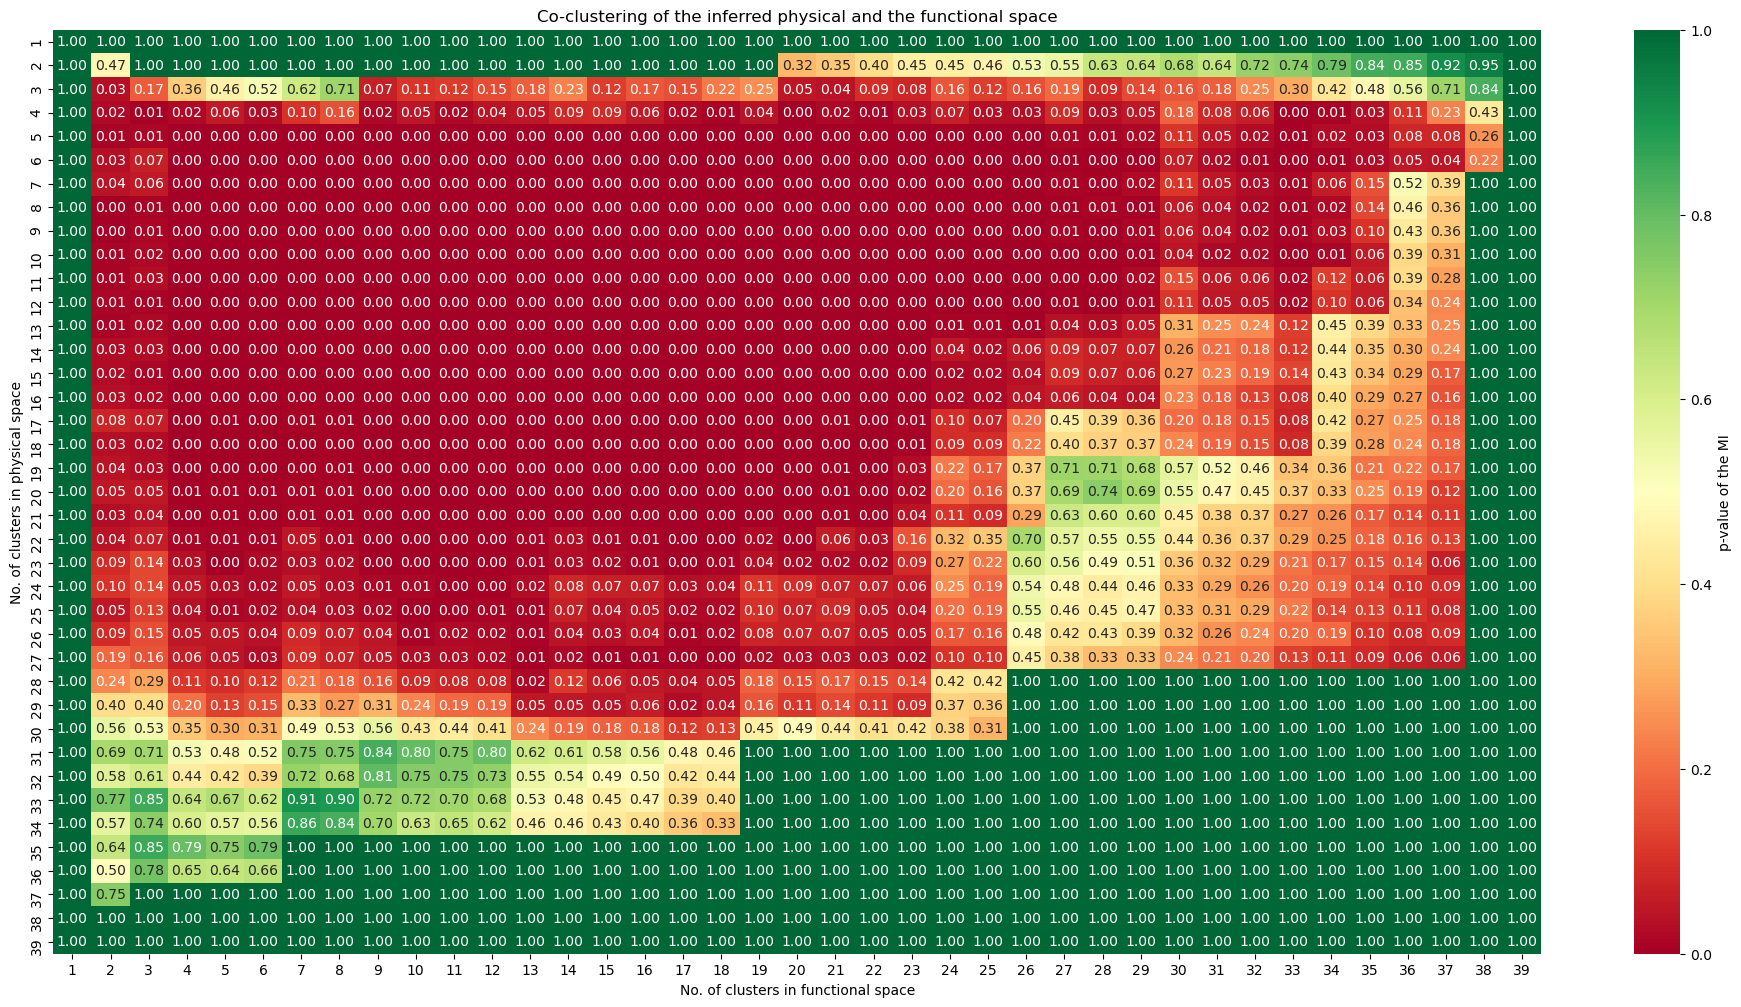

<IPython.core.display.Javascript object>

In [430]:
plot_cc_score(
    np.clip(cmap_perm_test_results["pval"], 0, 1),
    "Co-clustering of the inferred physical and the functional space",
    "p-value of the MI",
    figsize=[24, 12],
    fmt=".2f",
    cmap="RdYlGn",
    vmin=0,
    vmax=1,
    space_names=["functional space", "physical space"],
)

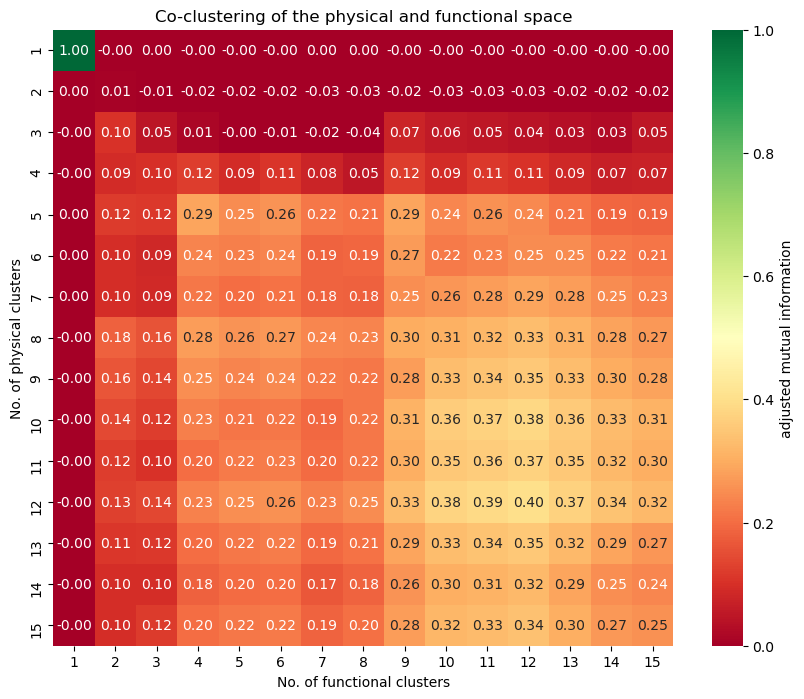

<IPython.core.display.Javascript object>

In [320]:
fig, ax = plt.subplots(figsize=[10, 8])
sns.heatmap(
    ami_img_cmap,
    cmap="RdYlGn",
    annot=True,
    fmt=".2f",
    ax=ax,
    vmin=0,
    vmax=1,
    cbar_kws={"label": "adjusted mutual information"},
)
ax.set_xticklabels([i + 1 for i in range(15)])
ax.set_yticklabels([i + 1 for i in range(15)])
ax.set_xlabel("No. of functional clusters")
ax.set_ylabel("No. of physical clusters")
ax.set_title("Co-clustering of the physical and functional space")
plt.show()

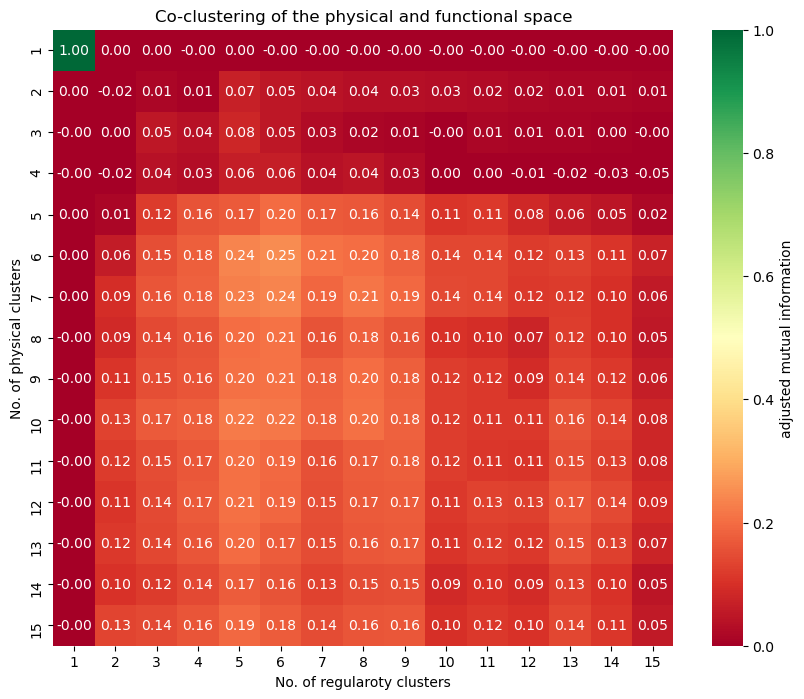

<IPython.core.display.Javascript object>

In [323]:
fig, ax = plt.subplots(figsize=[10, 8])
sns.heatmap(
    ami_img_node,
    cmap="RdYlGn",
    annot=True,
    fmt=".2f",
    ax=ax,
    vmin=0,
    vmax=1,
    cbar_kws={"label": "adjusted mutual information"},
)
ax.set_xticklabels([i + 1 for i in range(15)])
ax.set_yticklabels([i + 1 for i in range(15)])
ax.set_xlabel("No. of regularoty clusters")
ax.set_ylabel("No. of physical clusters")
ax.set_title("Co-clustering of the physical and functional space")
plt.show()

---

## 4. Data export

Inspired by the above co-clustering results we want to derive a regulatory network that is consists of genes covered in the CMAP signatures and is specifically enriched for the L1000 genes.

To this end, we will export the corresponding gene signature data set in addition to the L1000 gene set information.

In [92]:
with open("../../../data/other/genesets/l1000.txt", "w") as f:
    for item in sorted(l1000_genes):
        f.write("%s\n" % item)

mean_l5_data.to_csv("../../../data/gex/cmap/mean_l5_signatures.csv")

<IPython.core.display.Javascript object>